## Reload KINN and CNN

In [1]:
%cd ..
# reload and re-train to full convergence


from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import src
import amber
from src.reload import reload_from_dir
from src.kinetic_model import KineticModel, modelSpace_to_modelParams
from src.neural_network_builder import KineticNeuralNetworkBuilder, KineticEigenModelBuilder
from src.model_spaces import get_cas9_uniform_ms, get_cas9_finkelstein_ms
from src.data import load_finkelstein_data as get_data

import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import shutil
import os
import pickle
import gc
from sklearn.model_selection import train_test_split

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


Using TensorFlow backend.


In [2]:
# load data
target = "wtCas9_cleave_rate_log"

wd = "outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep4-gRNA1"
#wd = "outputs/final/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep5-gRNA2"

res = get_data(target=target, make_switch=wd.endswith('gRNA2'), logbase=10, include_ref=False)
# unpack data tuple
(x_train, y_train), (x_test, y_test) = res

In [3]:
# load kinn

# manager configs
manager_kwargs={
    'output_op': 
        lambda: tf.keras.layers.Lambda(lambda x: tf.math.log(tf.clip_by_value(x, 10**-5, 10**-1))/np.log(10), name="output_log10"),  # change the clip as well
        #lambda: tf.keras.layers.Lambda(lambda x: tf.math.log(tf.clip_by_value(tf.reshape(- x[:,1], (-1,1)), 10**-5, 10**-1))/np.log(10), name="output_slice"),
        #lambda: tf.keras.layers.Dense(units=1, activation="linear", name="output_nonneg", kernel_constraint=tf.keras.constraints.NonNeg()),

    'n_feats': 25,
    'n_channels': 9,
    'batch_size': 128,
    'epochs': 30,
    'earlystop': 10,
    'verbose': 0
}

kinn = reload_from_dir(wd=wd, manager_kwargs=manager_kwargs, model_fn=KineticNeuralNetworkBuilder)
#kinn = reload_from_dir(wd=wd, manager_kwargs=manager_kwargs, model_fn=KineticEigenModelBuilder)

loaded searched model


In [4]:
# load cnn
wd = "outputs/linear_offset/CNN-wtCas9_cleave_rate_log-sgRNA1"
train_hist = pd.read_table(os.path.join(wd, "train_history.csv"), sep=",", header=None)
best_trial_id = train_hist.sort_values(2, ascending=False).head(1)[0]
dcnn = tf.keras.models.load_model(os.path.join(wd, "weights", "trial_%i"%best_trial_id, "bestmodel.h5"))

# Retrain to full convergence

In [5]:
%matplotlib inline
retrain = isinstance(kinn, KineticEigenModelBuilder)
if retrain:
    y_hat = kinn.predict(x_test)
    print(ss.pearsonr(y_test, y_hat))
    checkpointer = ModelCheckpoint( filepath=os.path.join(wd,"bestmodel_retrain.h5"), mode='min', verbose=0, save_best_only=True, save_weights_only=True)
    earlystopper = EarlyStopping( monitor="val_loss", mode='min', patience=15, verbose=0)
    x_train_b = kinn.blockify_seq_ohe(x_train)
    x_test_b = kinn.blockify_seq_ohe(x_test)
    hist = kinn.model.fit(
        x_train_b, y_train,
        epochs=300,
        batch_size=512,
        validation_data=[x_test_b, y_test],
        callbacks=[checkpointer, earlystopper],
        verbose=2
    )
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')

In [6]:
# validate kinn
y_hat = kinn.predict(x_test)
print(y_hat.mean(), y_hat.max(), y_hat.min())
ss.pearsonr(y_test, y_hat)

-4.220348 -0.99999994 -4.9999995


(array([0.8591066526329764], dtype=object), 0.0)

Text(0, 0.5, 'Pred')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


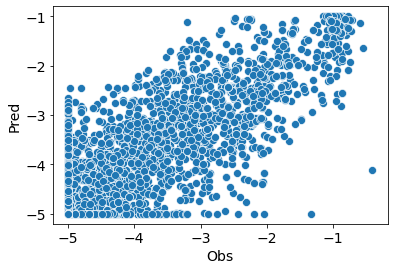

In [7]:
ax = sns.scatterplot(x=y_test, y=y_hat.flatten())
ax.set_xlabel('Obs')
ax.set_ylabel('Pred')


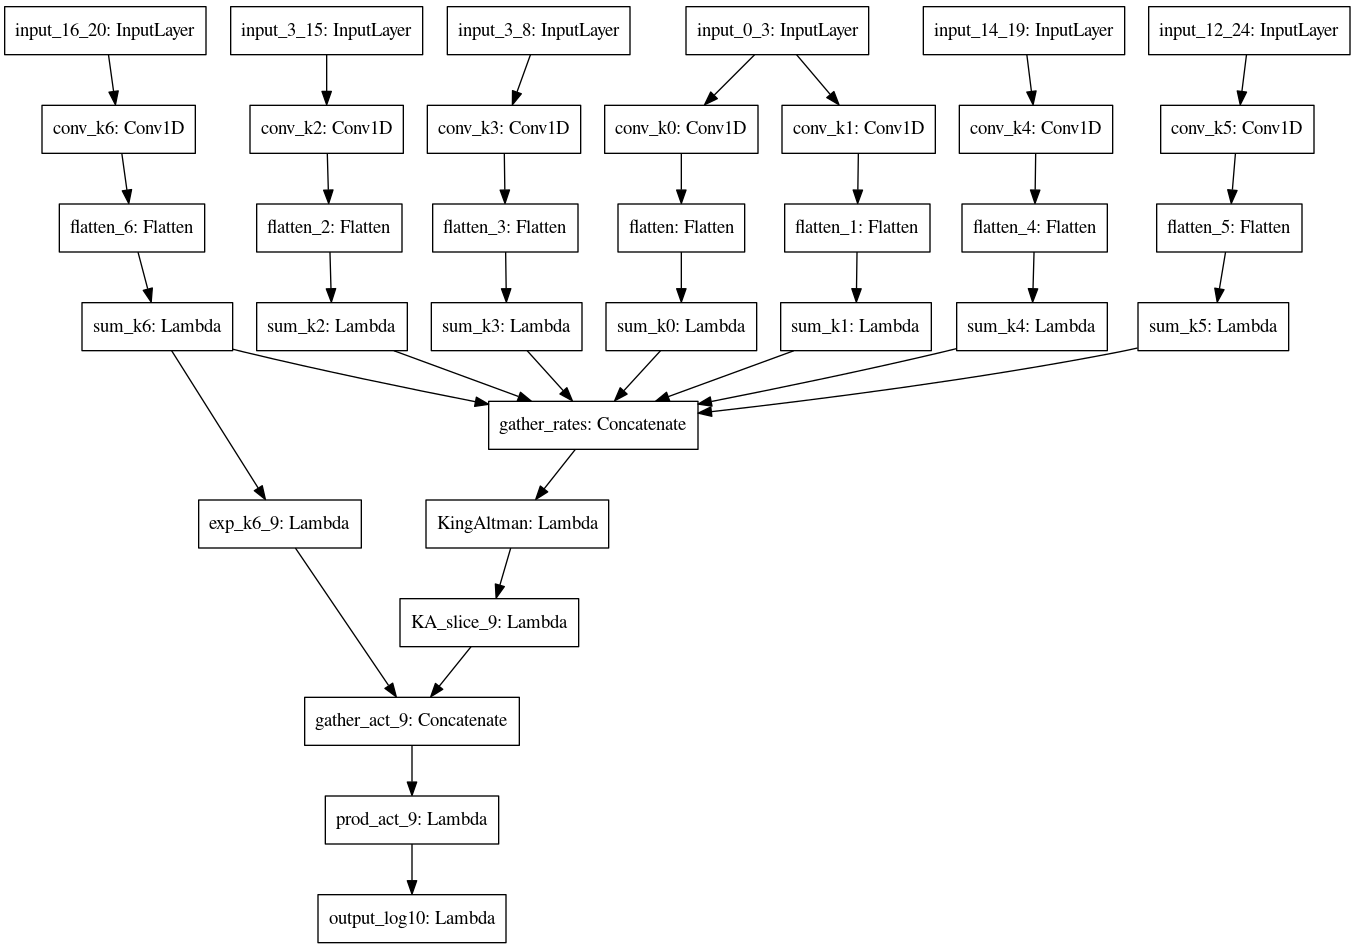

In [8]:
tf.keras.utils.plot_model(kinn.model)

# PWMs

In [9]:
layer_dict = {l.name:l for l in kinn.model.layers}

In [10]:
layer_id = "conv_k0"
print(np.around(layer_dict[layer_id].get_weights()[0],3))
print(np.around(layer_dict[layer_id].get_weights()[1],3))

[[[-1.472 -1.472]
  [-2.277 -2.277]
  [ 0.     0.   ]
  [-2.288 -2.288]
  [-0.054 -0.054]
  [-0.007 -0.007]
  [-0.019 -0.019]
  [-0.149 -0.149]
  [-2.053 -2.053]]

 [[-1.558 -1.558]
  [-2.449 -2.449]
  [ 0.     0.   ]
  [-2.301 -2.301]
  [-1.352 -1.352]
  [-1.707 -1.707]
  [ 0.     0.   ]
  [-2.088 -2.088]
  [ 0.     0.   ]]

 [[ 0.064  0.064]
  [ 0.158  0.158]
  [ 0.517  0.517]
  [ 0.     0.   ]
  [-1.065 -1.065]
  [-1.806 -1.806]
  [-1.05  -1.05 ]
  [-1.83  -1.83 ]
  [ 0.38   0.38 ]]]
[-0.382 -0.382]


In [11]:
layer_id = "conv_k1"
print(np.around(layer_dict[layer_id].get_weights()[0],3))
print(np.around(layer_dict[layer_id].get_weights()[1],3))

[[[ 1.503  1.503]
  [ 2.336  2.336]
  [ 0.     0.   ]
  [ 2.333  2.333]
  [ 0.102  0.102]
  [ 0.049  0.049]
  [ 0.09   0.09 ]
  [ 0.195  0.195]
  [ 2.1    2.1  ]]

 [[ 1.587  1.587]
  [ 2.484  2.484]
  [ 0.     0.   ]
  [ 2.369  2.369]
  [ 1.371  1.371]
  [ 1.754  1.754]
  [ 0.     0.   ]
  [ 2.087  2.087]
  [ 0.     0.   ]]

 [[-0.01  -0.01 ]
  [-0.116 -0.116]
  [-0.513 -0.513]
  [ 0.     0.   ]
  [ 1.111  1.111]
  [ 1.82   1.82 ]
  [ 1.046  1.046]
  [ 1.882  1.882]
  [-0.397 -0.397]]]
[0.458 0.458]


In [12]:
layer_id = "conv_k2"
print(np.around(layer_dict[layer_id].get_weights()[0],3))
print(np.around(layer_dict[layer_id].get_weights()[1],3))

[[[-1.06 ]
  [-1.095]
  [-0.472]
  [-1.538]
  [-0.642]
  [-1.35 ]
  [-0.754]
  [-1.281]
  [-0.98 ]]

 [[-0.842]
  [-0.343]
  [-0.472]
  [-1.076]
  [-1.072]
  [-1.289]
  [-1.05 ]
  [-1.296]
  [-0.824]]

 [[-0.842]
  [-0.628]
  [-1.245]
  [-1.332]
  [-1.077]
  [-0.974]
  [-1.064]
  [-0.927]
  [-0.742]]

 [[-0.842]
  [-0.352]
  [-0.696]
  [-0.708]
  [-1.073]
  [-0.922]
  [-0.762]
  [-0.825]
  [-0.74 ]]

 [[ 2.06 ]
  [-0.352]
  [-0.401]
  [ 0.446]
  [-1.24 ]
  [-1.309]
  [-0.685]
  [-1.258]
  [-0.812]]

 [[-2.091]
  [-1.022]
  [-0.401]
  [-0.428]
  [-0.806]
  [-1.456]
  [-1.923]
  [-1.239]
  [-0.854]]

 [[ 0.687]
  [-1.022]
  [ 0.233]
  [-0.456]
  [-0.729]
  [-1.436]
  [ 0.228]
  [-0.559]
  [-0.853]]]
[0.006]


In [13]:
layer_id = "conv_k3"
print(np.around(layer_dict[layer_id].get_weights()[0],3))
print(np.around(layer_dict[layer_id].get_weights()[1],3))

[[[ 0.246  0.246]
  [ 0.546  0.546]
  [ 1.661  1.661]
  [-0.398 -0.398]
  [ 1.116  1.116]
  [ 0.23   0.23 ]
  [-0.299 -0.299]
  [ 0.936  0.936]
  [ 0.525  0.525]]]
[0.03 0.03]


In [14]:
layer_id = "conv_k4"
print(np.around(layer_dict[layer_id].get_weights()[0],3))
print(np.around(layer_dict[layer_id].get_weights()[1],3))

[[[-0.127 -0.127 -0.127]
  [-0.138 -0.138 -0.138]
  [-0.446 -0.446 -0.446]
  [-0.156 -0.156 -0.156]
  [-0.489 -0.489 -0.489]
  [-0.459 -0.459 -0.459]
  [-0.464 -0.464 -0.464]
  [-0.76  -0.76  -0.76 ]
  [-0.906 -0.906 -0.906]]

 [[-0.127 -0.127 -0.127]
  [-0.229 -0.229 -0.229]
  [-0.148 -0.148 -0.148]
  [-0.423 -0.423 -0.423]
  [-0.513 -0.513 -0.513]
  [-0.476 -0.476 -0.476]
  [-0.447 -0.447 -0.447]
  [-0.458 -0.458 -0.458]
  [-0.293 -0.293 -0.293]]

 [[-0.346 -0.346 -0.346]
  [-0.229 -0.229 -0.229]
  [-0.134 -0.134 -0.134]
  [ 0.122  0.122  0.122]
  [-0.26  -0.26  -0.26 ]
  [-0.502 -0.502 -0.502]
  [-0.084 -0.084 -0.084]
  [-0.202 -0.202 -0.202]
  [-0.142 -0.142 -0.142]]

 [[-0.346 -0.346 -0.346]
  [-0.928 -0.928 -0.928]
  [-0.863 -0.863 -0.863]
  [-0.771 -0.771 -0.771]
  [-0.261 -0.261 -0.261]
  [-0.593 -0.593 -0.593]
  [-0.658 -0.658 -0.658]
  [-0.342 -0.342 -0.342]
  [-0.141 -0.141 -0.141]]

 [[-0.346 -0.346 -0.346]
  [ 0.593  0.593  0.593]
  [-0.339 -0.339 -0.339]
  [ 0.386  0.386 

In [15]:
layer_id = "conv_k5"
print(np.around(layer_dict[layer_id].get_weights()[0],3))
print(np.around(layer_dict[layer_id].get_weights()[1],3))

[[[ 0.34   0.34   0.34 ]
  [ 0.325  0.325  0.325]
  [ 0.205  0.205  0.205]
  [ 0.186  0.186  0.186]
  [ 0.357  0.357  0.357]
  [ 0.676  0.676  0.676]
  [ 0.67   0.67   0.67 ]
  [ 0.566  0.566  0.566]
  [ 1.147  1.147  1.147]]

 [[ 0.34   0.34   0.34 ]
  [ 0.564  0.564  0.564]
  [ 0.337  0.337  0.337]
  [ 0.321  0.321  0.321]
  [ 0.357  0.357  0.357]
  [ 0.676  0.676  0.676]
  [ 0.67   0.67   0.67 ]
  [ 0.566  0.566  0.566]
  [ 0.653  0.653  0.653]]

 [[ 0.023  0.023  0.023]
  [ 0.006  0.006  0.006]
  [ 0.337  0.337  0.337]
  [ 0.188  0.188  0.188]
  [ 0.162  0.162  0.162]
  [-0.016 -0.016 -0.016]
  [ 0.268  0.268  0.268]
  [ 0.101  0.101  0.101]
  [ 0.024  0.024  0.024]]

 [[ 0.023  0.023  0.023]
  [ 0.006  0.006  0.006]
  [ 0.337  0.337  0.337]
  [ 0.188  0.188  0.188]
  [ 0.162  0.162  0.162]
  [-0.016 -0.016 -0.016]
  [ 0.268  0.268  0.268]
  [ 0.101  0.101  0.101]
  [ 0.024  0.024  0.024]]

 [[-0.027 -0.027 -0.027]
  [ 0.379  0.379  0.379]
  [ 0.337  0.337  0.337]
  [ 0.234  0.234 

In [16]:
layer_id = "conv_k6"
print(np.around(layer_dict[layer_id].get_weights()[0],3))
print(np.around(layer_dict[layer_id].get_weights()[1],3))

[[[-0.262]
  [ 0.348]
  [-0.226]
  [-0.911]
  [-0.918]
  [ 0.235]
  [-0.651]
  [-0.525]
  [-0.073]]

 [[-0.94 ]
  [ 0.348]
  [-0.313]
  [ 0.466]
  [-0.14 ]
  [-0.188]
  [ 0.119]
  [-0.154]
  [ 0.139]]

 [[-0.166]
  [ 0.008]
  [-0.313]
  [-0.817]
  [-0.715]
  [ 0.665]
  [-0.24 ]
  [-0.325]
  [-0.639]]

 [[-0.113]
  [-0.583]
  [ 0.123]
  [-0.817]
  [-0.663]
  [ 0.743]
  [-0.017]
  [ 0.042]
  [-0.424]]

 [[-0.113]
  [-0.475]
  [-0.333]
  [-0.64 ]
  [-0.352]
  [ 0.79 ]
  [ 0.167]
  [ 0.019]
  [-0.735]]]
[0.061]


# kinetic rates

In [17]:
# rate model
layer_dict = {l.name:l for l in kinn.model.layers}
rate_mod = tf.keras.models.Model(inputs=kinn.model.inputs, outputs=layer_dict['gather_rates'].output) 

In [18]:
matched = np.zeros((1,25,9))

rates_ = rate_mod.predict(kinn.blockify_seq_ohe(matched)).flatten()
rates = np.log10(np.exp(rates_))
print("kinn rate for matched\n")
for i in range(7):
    r = rates[i]
    print("k_%i"%i, r)


kinn rate for matched

k_0 -0.33218035
k_1 0.3975166
k_2 0.03276875
k_3 0.12984243
k_4 0.62228805
k_5 -1.488582
k_6 0.10532506


In [19]:
if isinstance(kinn, KineticEigenModelBuilder):
    eig_mod = tf.keras.models.Model(inputs=kinn.model.inputs, outputs=kinn.model.layers[-2].output)
    evs = eig_mod.predict(kinn.blockify_seq_ohe(matched))
    # part of minimized loss; should be small
    print('lams', evs)
    print('lam_1/lam_2', evs[:,1] / evs[:,2])


In [20]:
scatter_ind = [
        [((0,0), -1), ((1,0),  1), ],
        [((0,1),  1), ((1,1), -1), ],
        [((1,1), -1), ((2,1),  1), ],
        [((1,2),  1), ((2,2), -1), ],
        [((2,2), -1), ((3,2),  1), ],
        [((2,3),  1), ((3,3), -1), ],
        [((3,3), -1), ((4,3),  1), ]
]
def make_kinetic_matrix(vec):
    mat = np.zeros((5,5))
    for i, value in enumerate(vec):
        scater_inds = scatter_ind[i]
        for idx, sign in scater_inds:
            mat[idx] += value * sign
    return mat

def get_first_eigval(vec):
    mat = make_kinetic_matrix(vec)
    eigvals, eigvecs = np.linalg.eig(mat)
    lam_1 = sorted(eigvals, reverse=True)[0:3]
    return lam_1

evs = get_first_eigval(np.exp(rates_))
print('lams', evs)
print('pred lam_1', np.log10(-evs[1]))
print('lam_1/lam_2', evs[1]/evs[2])

lams [0.0, -0.10222485297005175, -1.271848523606764]
pred lam_1 -0.9904435054186851
lam_1/lam_2 0.08037502192490503


<AxesSubplot:title={'center':'Reverse'}>

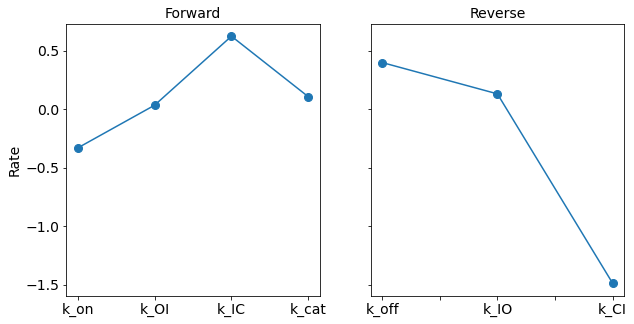

In [21]:
%matplotlib inline
rate_names = ['k_on', 'k_off', 'k_OI', 'k_IO', 'k_IC', 'k_CI', 'k_cat']
rate_df = pd.DataFrame({'rate': rates}, index=rate_names)
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=True)
rate_df.loc[['k_on', 'k_OI', 'k_IC', 'k_cat']].plot(ax=axs[0], legend=False, style='-o', title="Forward", 
                                                    ylabel="Rate")
rate_df.loc[['k_off', 'k_IO', 'k_CI']].plot(ax=axs[1], legend=False, style='-o', title="Reverse")
#axs[0].set_ylim(0,7)


In [22]:
matched = np.zeros((1,25,9))

print("kinn matched:", kinn.predict(matched).flatten())
print("dcnn matched:", dcnn.predict(matched).flatten())

kinn matched: [-1.042578]
dcnn matched: [-0.9846239]


## Error residuals distributions comparison

In [23]:
def make_err_plot(x, y, ax=None):
    kinn_pred = kinn.predict(x)
    cnn_pred = dcnn.predict(x)
    df = pd.DataFrame({'kinn_err':y - kinn_pred.flatten(), 'cnn_err':y - cnn_pred.flatten()}, 
                      index=np.arange(len(kinn_pred)))
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax = sns.kdeplot(x='kinn_err', y='cnn_err', data=df, ax=ax)
    #ax.set_xlim(-3,3)
    #ax.set_ylim(-3,3)
    ax.plot([0,1], [0,1], transform=ax.transAxes, ls='--', c="red")
    ax.axvline(0, ls="--", c="grey")
    ax.axhline(0, ls="--", c="grey")
    ax.set_xlabel("KINN error\n(mae=%.2f)"%df['kinn_err'].abs().mean())
    ax.set_ylabel("CNN error\n(mae=%.2f)"%df['cnn_err'].abs().mean())
    ax.set_title("Error residual pcc=%.3f" % ss.pearsonr(df['kinn_err'], df['cnn_err'])[0])
    return ax

Text(0.5, 1.0, 'sgRNA 2 Test\nError residual pcc=0.734')

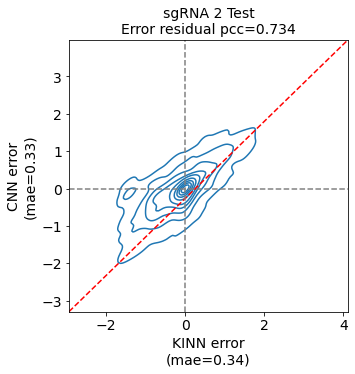

In [24]:
%matplotlib inline

ax = make_err_plot(x_test, y_test)
ax.set_title("sgRNA 2 Test\n" + ax.get_title())

## In-sillico mutagenesis

In [25]:
def in_sillico_mutagen(x, model, verbose=False):
    score = np.zeros(x.shape)
    ref = model.predict(x).flatten()
    ref = np.clip(ref, -5, -1)
    for i in range(x.shape[-2]):
        for j in range(x.shape[-1]):
            x_m = x.copy()
            x_m[:,i] = 0
            x_m[:,i,j] = 1
            score[:,i,j] = ref - np.clip(model.predict(x_m).flatten(), -5, -1)
    return score.squeeze()
        

In [26]:
# get effects - s1: KINN, s2: dcnn
s1 = in_sillico_mutagen(matched, kinn)[2:]
s2 = in_sillico_mutagen(matched, dcnn)[2:]

Text(0.5, 1.0, 'Mutation effects comparison\npcc=0.919')

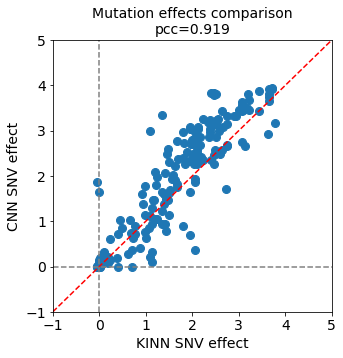

In [27]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.set_xlim(-1,5)
ax.set_ylim(-1,5)
ax.scatter(s1.reshape(-1), s2.reshape(-1))
ax.plot([0,1], [0,1], transform=ax.transAxes, ls='--', c="red")
ax.set_xlabel("KINN SNV effect")
ax.set_ylabel("CNN SNV effect")
ax.axvline(0, ls="--", c="grey")
ax.axhline(0, ls="--", c="grey")
ax.set_title("Mutation effects comparison\npcc=%.3f" % ss.pearsonr(s1.reshape(-1), s2.reshape(-1))[0])

In [28]:
# no existing 2nd G deletion in training data of sgRNA1.
max(x_train[:,1,-1])

0.0

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


<AxesSubplot:title={'center':'SNV in Matched: CNN'}>

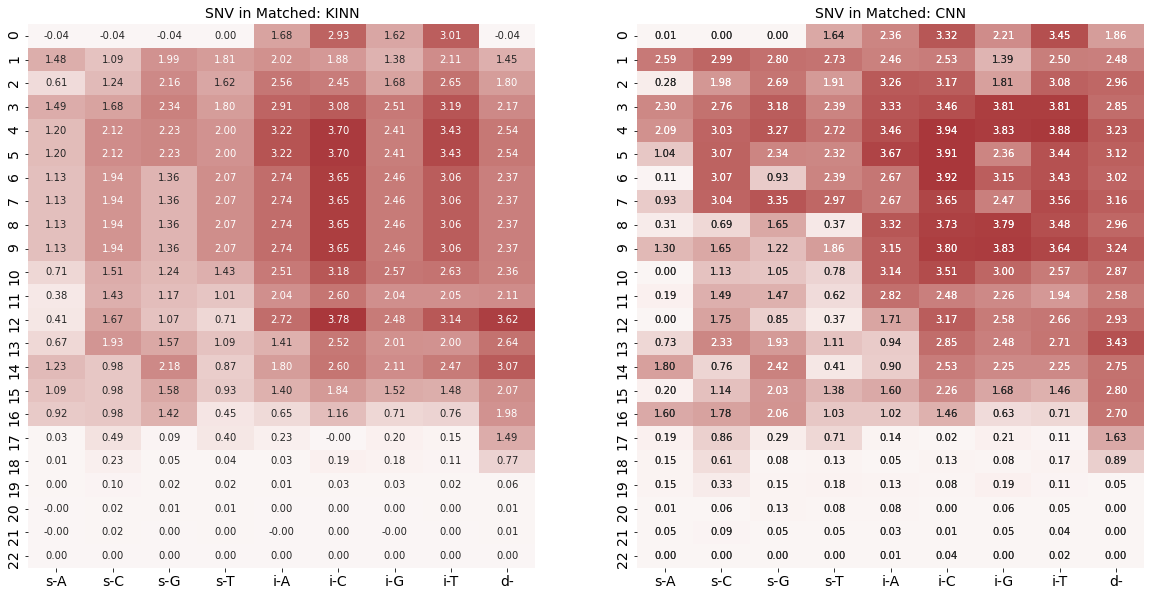

In [29]:
# thus, do not include the first 2 Gs
fig, axs = plt.subplots(1,2, figsize=(20,10))

sns.heatmap(s1, annot=True, ax=axs[0], center=0, cbar=False, fmt=".2f", 
            cmap=sns.color_palette("vlag", as_cmap=True),
            xticklabels=['s-A','s-C','s-G','s-T','i-A','i-C','i-G','i-T','d-']
)
axs[0].set_title('SNV in Matched: KINN')
sns.heatmap(s2, annot=True, ax=axs[1], center=0, cbar=False, fmt=".2f", 
            cmap=sns.color_palette("vlag", as_cmap=True),
            xticklabels=['s-A','s-C','s-G','s-T','i-A','i-C','i-G','i-T','d-']
)

axs[1].set_title('SNV in Matched: CNN')
sns.heatmap(s2, annot=True, ax=axs[1], center=0, cbar=False, fmt=".2f", 
            cmap=sns.color_palette("vlag", as_cmap=True),
            xticklabels=['s-A','s-C','s-G','s-T','i-A','i-C','i-G','i-T','d-']
)

#axs[2].set_title('SNV KINN - CNN')
#sns.heatmap(s1-s2, annot=True, ax=axs[2], center=0, cbar=False, fmt=".2f", 
#            cmap=sns.color_palette("vlag", as_cmap=True),
#            xticklabels=['s-A','s-C','s-G','s-T','i-A','i-C','i-G','i-T','d-']
#)

In [30]:
s_kinn = in_sillico_mutagen(x_test, kinn)[:,2:]
s_dcnn = in_sillico_mutagen(x_test, dcnn)[:,2:]

Text(0.5, 1.0, 'SNV in Total - CNN')

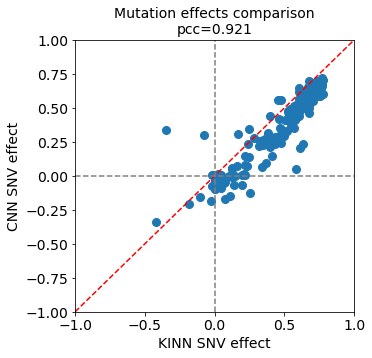

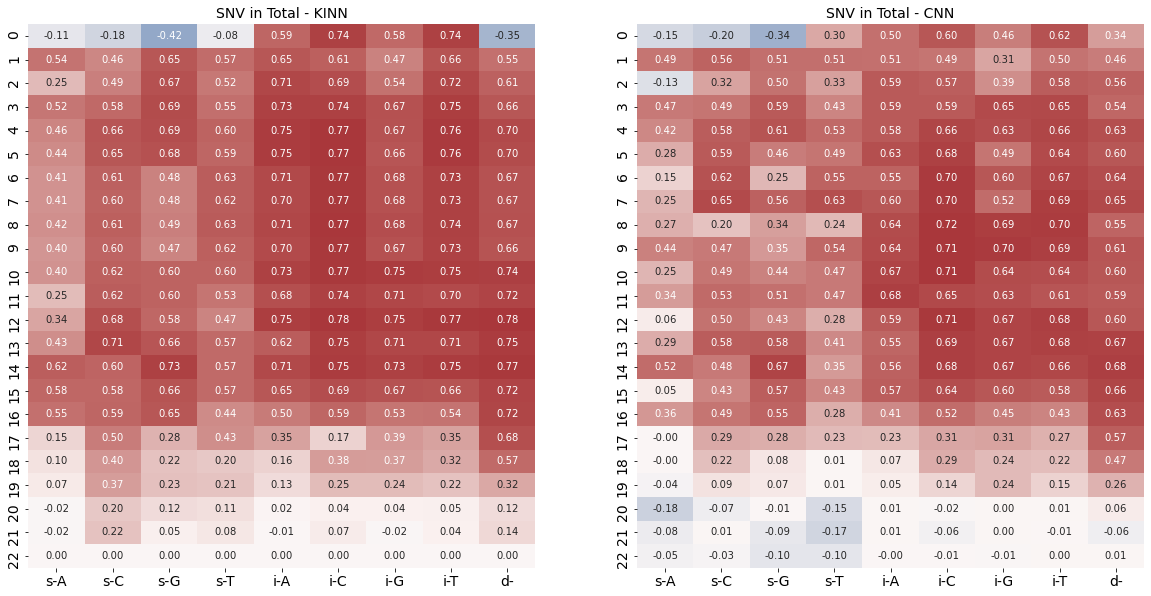

In [31]:
s1 = s_kinn.mean(axis=0)
s2 = s_dcnn.mean(axis=0)

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.scatter(s1.reshape(-1), s2.reshape(-1))
ax.plot([0,1], [0,1], transform=ax.transAxes, ls='--', c="red")
ax.set_xlabel("KINN SNV effect")
ax.set_ylabel("CNN SNV effect")
ax.axvline(0, ls="--", c="grey")
ax.axhline(0, ls="--", c="grey")
ax.set_title("Mutation effects comparison\npcc=%.3f" % ss.pearsonr(s1.reshape(-1), s2.reshape(-1))[0])

fig, axs = plt.subplots(1,2, figsize=(20,10))
sns.heatmap(s1, annot=True, ax=axs[0], center=0, cbar=False, fmt=".2f", 
            cmap=sns.color_palette("vlag", as_cmap=True),
            xticklabels=['s-A','s-C','s-G','s-T','i-A','i-C','i-G','i-T','d-']
)
axs[0].set_title('SNV in Total - KINN')
sns.heatmap(s2, annot=True, ax=axs[1], center=0, cbar=False, fmt=".2f", 
            cmap=sns.color_palette("vlag", as_cmap=True),
            xticklabels=['s-A','s-C','s-G','s-T','i-A','i-C','i-G','i-T','d-']
)
axs[1].set_title('SNV in Total - CNN')

In [32]:
def pretty_print(mat):
    for i, r in enumerate(mat):
        sub, indel = r[0:4], r[4:]
        if sum(sub) == 0:
            s = ''
        else:
            s = 'sub:' + 'ACGT'[np.where(sub==1)[0][0]]
        if sum(indel) == 0:
            ind = ''
        else:
            ind = 'indel:' + 'ACGT-'[np.where(indel==1)[0][0]]
        
        if not s and not ind:
            m = "match"
        else:
            m = ''
        print('row %i\t'%i, m, s, ind)
        #print('row ', i, r)

pretty_print(x_test[523])

row 0	 match  
row 1	 match  
row 2	 match  
row 3	 match  
row 4	 match  
row 5	 match  
row 6	 match  
row 7	 match  
row 8	 match  
row 9	 match  
row 10	 match  
row 11	 match  
row 12	 match  
row 13	 match  
row 14	   indel:T
row 15	 match  
row 16	 match  
row 17	 match  
row 18	 match  
row 19	 match  
row 20	   indel:G
row 21	 match  
row 22	 match  
row 23	 match  
row 24	 match  


In [33]:
kinn.predict(x_test[[523]]), dcnn.predict(x_test[[523]]), y_test[523]

(array([[-4.9999995]], dtype=float32),
 array([[-5.0812917]], dtype=float32),
 -5.0)

In [34]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Aug 30 2022

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.22.0

amber     : 0.1.2
tensorflow: 1.15.0
src       : 0.0.1
matplotlib: 3.4.3
scipy     : 1.7.3
numpy     : 1.21.6
seaborn   : 0.11.1
pandas    : 1.3.5

Watermark: 2.3.1

